In [1]:
#!gdown --id 1tV-TWBqet6R_oDc1lEInAmjBSvk-EMml
#!gdown --id 1jqtA93q5bckLLbZi_g_D4VNdsCC2HU9f
#!gdown --id 1gKH_bQ3CtmirmznKj12_gZy3vGhD_d0m

In [2]:
#!nvidia-smi

In [3]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 4GB of memory on the first GPU
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
import pandas as pd
import re
import numpy as np
import itertools
import collections
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
import string
from wordcloud import WordCloud

import nltk
nltk.download('treebank')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import word_tokenize, pos_tag

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer 

import gensim
from gensim.models import KeyedVectors, Word2Vec, FastText

import tensorflow as tf
import unicodedata

[nltk_data] Downloading package treebank to
[nltk_data]     C:\Users\phvpa\AppData\Roaming\nltk_data...
[nltk_data]   Package treebank is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\phvpa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\phvpa\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\phvpa\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\phvpa\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
C:\Users\phvpa\anaconda3\envs\NLP\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, b

In [5]:
#ls

In [6]:

train_df = pd.read_csv("tamil_sentiment_full_train.tsv", sep='\t')
print(len(train_df))

valid_df = pd.read_csv("tamil_sentiment_full_dev.tsv", sep='\t')
print(len(valid_df))

test_df = pd.read_csv("tamil_sentiment_full_test_withoutlabels.tsv", sep='\t')
len(test_df)

35656
3962


4402

In [7]:
test_df

,id,text
0,Tam_1,வீர செங்குந்தர் சார்பாக இந்த திரைப்படம் வெற்றி...
1,Tam_2,Teruk ah irukku .... mokke movie .. waste of time
2,Tam_3,manitha samuthaayam amaipil irunthu intha pada...
3,Tam_4,JJ mam we miss u
4,Tam_5,Subtitle me traller dekhne wale like karo
...,...,...
4397,Tam_4398,Ithukum dislike potta kammanattti koovaingalam...
4398,Tam_4399,Suyama Sinthikiravan than super Hero Seama dia...
4399,Tam_4400,Super thalaiva.... Nee mass dha eppavume
4400,Tam_4401,பெண்ணை அடிமையாக்க நினைக்கும் இந்த படம் தோல்வித...


In [8]:
print(test_df['text'][279])
print(test_df['text'][516])
print(test_df['text'][546])
print(test_df['text'][555])
print(test_df['text'][559])
print(test_df['text'][570])
print(test_df['text'][825])
print(test_df['text'][838])
print(test_df['text'][860])
print(test_df['text'][890])
print(test_df['text'][1234])

The King is Arriving.....  Anil Kunjugal Padhungum Neram Vandhu vitadhu.....
ஆக மொத்தம் , விவசாயிங்க கண்ணிர், இளைஞர்கள் வேலைவாய்ப்பு, விலைவாசி உயர்வு, நாட்டின் முன்னேற்றம் பற்றி எந்த நாயிம் படம் எடுக்காது.  போங்கடா நீங்களும் உங்க ஜாதி புண்** யும்.
Verithanama iruka pogithu athula doubt te ila
luv u ರಜನಿ... luv from Karnataka
Padipa mattum  eduthuka  mudiyathu.....
Masssss Na massss dha pakkkkaaaaa masssssss ummmmmmhhaaaa
Thalaiva  Makkal selvan Annan
1m likes kooda oomba mudila   Fan base matter
Wow....... Ak is looking.... Very dangerous.... ...
Vj Sethupathi Ah Kamichitu Piragu Tha Trailer eh Mass Ah Poovthu ..!
epdi thalaivare? all star vachi padam pandringa? marana waiding.... 🤗🤗🤗🤗


In [9]:
train_df['text'][0]

'Vani bhojam fans hit like solli 500 like Vangida Vendiyathu than'

In [10]:
train_df

,text,category
0,Vani bhojam fans hit like solli 500 like Vangi...,unknown_state
1,I love you ajith very I like,Positive
2,ennaya trailer Ku mudi Ellam nikkudhu... Vera ...,Positive
3,Vijay Annaa Ur Maassssss Therrrrriiiiii,Positive
4,நம்ப நடே நாசாமா தான் போச்சி,Negative
...,...,...
35651,ஒருவர் செய்த தவறுக்காக எல்லாரையும் பழி போடுவது...,Mixed_feelings
35652,Repeated Mode to Watching Theri Trailer & Ther...,Positive
35653,yeevanikuachu pula kutti erudhal oodi poyidu....,Negative
35654,She is looking like laughing budha,Positive


In [11]:
valid_df

,text,category
0,@0:40 songsuperb..kamallllla.. I'm waiting fo...,unknown_state
1,கணத்ததோர் அகமுடையார் சார்பாக படம் வெற்றி அடைய...,Positive
2,Thalavia neenga veera level boss and neega tha...,Positive
3,Oru padam patha fell.vera level music,Positive
4,Hairstyle than mattama iruku. Adhu mattum math...,unknown_state
...,...,...
3957,நாடக காதல் மிகப்பெரிய தவறு. இதை தான் இந்த படம்...,Positive
3958,So long to see you suriya,not-Tamil
3959,Super sK ettan adipoli makkalle dec20 waiti...,Mixed_feelings
3960,Minimum 50m viewa vara veppoma all thala fans,Positive


In [12]:
valid_df['text']

0       @0:40 songsuperb..kamallllla..  I'm waiting fo...
1       கணத்ததோர் அகமுடையார் சார்பாக  படம் வெற்றி அடைய...
2       Thalavia neenga veera level boss and neega tha...
3                   Oru padam patha fell.vera level music
4       Hairstyle than mattama iruku. Adhu mattum math...
                              ...                        
3957    நாடக காதல் மிகப்பெரிய தவறு. இதை தான் இந்த படம்...
3958                            So long to see you suriya
3959    Super  sK  ettan adipoli makkalle dec20  waiti...
3960        Minimum 50m viewa vara veppoma all thala fans
3961                       Vera Vera level da version 2.0
Name: text, Length: 3962, dtype: object

In [13]:
len(train_df)

35656

In [14]:
for i in range(len(train_df)):
  if (train_df['category'][i] == 'Positive '):
    print(i)

32852


In [15]:
train_df['category'][32852]

'Positive '

In [16]:
train_df['category'][32852] = 'Positive'
train_df['category'][32852]

'Positive'

In [17]:
#removing all the emoji from the given data

def deEmojify(text):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642"
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
        "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'',text)


for i in range(len(train_df)):
    temp1 = deEmojify(train_df['text'][i])
    train_df['text'][i] = temp1

for j in range(len(valid_df)):
    temp2 = deEmojify(valid_df['text'][j])
    valid_df['text'][j] = temp2

for k in range(len(test_df)):
    temp3 = deEmojify(test_df['text'][k])
    test_df['text'][k]=temp3

In [18]:
print(test_df['text'][516])
print(test_df['text'][546])
print(test_df['text'][555])
print(test_df['text'][559])
print(test_df['text'][570])
print(test_df['text'][825])
print(test_df['text'][838])
print(test_df['text'][860])
print(test_df['text'][890])
print(test_df['text'][1234])

ஆக மொத்தம் , விவசாயிங்க கண்ணிர், இளைஞர்கள் வேலைவாய்ப்பு, விலைவாசி உயர்வு, நாட்டின் முன்னேற்றம் பற்றி எந்த நாயிம் படம் எடுக்காது.  போங்கடா நீங்களும் உங்க ஜாதி புண்** யும்.
Verithanama iruka pogithu athula doubt te ila
luv u ರಜನಿ... luv from Karnataka
Padipa mattum  eduthuka  mudiyathu.....
Masssss Na massss dha pakkkkaaaaa masssssss ummmmmmhhaaaa
Thalaiva  Makkal selvan Annan
1m likes kooda oomba mudila   Fan base matter
Wow....... Ak is looking.... Very dangerous.... ...
Vj Sethupathi Ah Kamichitu Piragu Tha Trailer eh Mass Ah Poovthu ..!
epdi thalaivare? all star vachi padam pandringa? marana waiding.... 


In [19]:
def preprocess_data(text):
  user_name = '@[A-Za-z0-9]+' # Pattern for matching the user names in the tweet
  has_tag = '#[A-Za-z0-9]+' # Pattern for matching the hasgtags in the tweer
  url = 'https?:\/\/[A-Za-z0-9\.\/\-]+' # Pattern for matching the URLs in the tweet
  #emoji_pattern = r'/[x{1F600}-x{1F64F}]/u'
  
  x = text.lower()  # Lower casing all the characters
  x = re.sub(user_name, '', x) # Replace the username with an empty characrer
  x = re.sub(has_tag,'',x) # Replace the hashtags with an empty characrer
  x = re.sub(url, '', x) # Replace the URLs with an empty characrer
  #x = re.sub(emoji_pattern, '', x)
  x = x.translate(str.maketrans('', '', string.punctuation)) # Replace all the characters except alphabets and digits from the tweet

  return x

In [20]:
train_df['text'] = train_df['text'].apply(lambda x: preprocess_data(x)) # Apply the clean_data() to all the entries in the dataframe
valid_df['text'] = valid_df['text'].apply(lambda x: preprocess_data(x)) # Apply the clean_data() to all the entries in the dataframe
test_df['text'] = test_df['text'].apply(lambda x: preprocess_data(x)) # Apply the clean_data() to all the entries in the dataframe

In [21]:
print(test_df['text'][279])
print(test_df['text'][516])
print(test_df['text'][546])
print(test_df['text'][555])
print(test_df['text'][559])
print(test_df['text'][570])
print(test_df['text'][825])
print(test_df['text'][838])
print(test_df['text'][860])
print(test_df['text'][890])
print(test_df['text'][1234])

the king is arriving  anil kunjugal padhungum neram vandhu vitadhu
ஆக மொத்தம்  விவசாயிங்க கண்ணிர் இளைஞர்கள் வேலைவாய்ப்பு விலைவாசி உயர்வு நாட்டின் முன்னேற்றம் பற்றி எந்த நாயிம் படம் எடுக்காது  போங்கடா நீங்களும் உங்க ஜாதி புண் யும்
verithanama iruka pogithu athula doubt te ila
luv u ರಜನಿ luv from karnataka
padipa mattum  eduthuka  mudiyathu
masssss na massss dha pakkkkaaaaa masssssss ummmmmmhhaaaa
thalaiva  makkal selvan annan
1m likes kooda oomba mudila   fan base matter
wow ak is looking very dangerous 
vj sethupathi ah kamichitu piragu tha trailer eh mass ah poovthu 
epdi thalaivare all star vachi padam pandringa marana waiding 


In [22]:
valid_df['text'][0]

'40 songsuperbkamallllla  im waiting for dis song you'

In [23]:
print(train_df)
print()
#print(valid_df.head())
#print()
print(valid_df)
print()
print(test_df)

                                                    text        category
0      vani bhojam fans hit like solli 500 like vangi...   unknown_state
1                           i love you ajith very i like        Positive
2      ennaya trailer ku mudi ellam nikkudhu vera lev...        Positive
3               vijay annaa  ur maassssss therrrrriiiiii        Positive
4                            நம்ப நடே நாசாமா தான் போச்சி        Negative
...                                                  ...             ...
35651  ஒருவர் செய்த தவறுக்காக எல்லாரையும் பழி போடுவது...  Mixed_feelings
35652  repeated mode to watching theri trailer  theri...        Positive
35653  yeevanikuachu  pula kutti erudhal oodi poyidu ...        Negative
35654                 she is looking like laughing budha        Positive
35655                     north or south kgf is the best        Positive

[35656 rows x 2 columns]

                                                   text        category
0     40 songsuperbkamall

In [24]:
train_text = train_df['text'].tolist()
valid_text = valid_df['text'].tolist()
test_text = test_df['text'].tolist()

train_label = train_df['category'].tolist()
valid_label = valid_df['category'].tolist()


In [25]:
test_text

['வீர செங்குந்தர் சார்பாக இந்த திரைப்படம் வெற்றி பெற வாழ்த்துக்கள் இயக்குனர் மோகன்g அவர்களுக்கு எங்கள் சமுதாயத்தின் சார்பாக வாழ்த்துக்கள்',
 'teruk ah irukku  mokke movie  waste of time',
 'manitha samuthaayam amaipil irunthu intha padam vetri adaiya vaalthukal',
 'jj mam we miss u',
 'subtitle me traller dekhne wale like karo',
 'என்னடா இது சிஸ்டத்தை வச்சு செய்ஞ்சுட்டானுங்க ',
 'ஒரு ஆளு உன்ன எதிர்த்தா நீ வளர அதுவே  பல கூட்டமே உன்னை எதுத்து கதருதுனா  நீ வளந்துட்டனு அர்த்தம்   இப்படம் நாடக காதலுக்கும் உன்மை காதலை ஆனவ கொலை செய்வோர்க்கு சாட்டை அடியாக இருக்கும் என எதிர் பார்க்கப்படுகிறது வெற்றி பெற வாழ்த்துக்கள்',
 'ayutha ezhuthu 2 semmai m waiting',
 '150 to 155  vera level mass',
 '16 varushama rajini arasiyalukku varuvennu sollittu irukkaaru aaana innum varala ha ha ha',
 'makkal selvan fan from tollywood   we need u makkal in tollywood',
 'str and arun vj vera leavel',
 'thalas hardwork  dedication in the movie next level  ',
 'raniji arasial idhu 96 semma bro',
 'நாடார் சார்பாக படம் 

In [26]:
class_names = list(set(train_label))
class_names

['Mixed_feelings', 'unknown_state', 'not-Tamil', 'Negative', 'Positive']

In [27]:
len(train_label)

35656

In [28]:
class_dist = Counter(train_label)
class_dist

Counter({'unknown_state': 5628,
         'Positive': 20070,
         'Negative': 4271,
         'Mixed_feelings': 4020,
         'not-Tamil': 1667})

In [29]:
class_dist = Counter(valid_label)
class_dist

Counter({'unknown_state': 611,
         'Positive': 2257,
         'Mixed_feelings': 438,
         'Negative': 480,
         'not-Tamil': 176})

In [30]:
le = LabelEncoder()

train_label = le.fit_transform(train_label)
train_label

array([4, 2, 2, ..., 1, 2, 2], dtype=int64)

In [31]:
valid_label = le.fit_transform(valid_label)
valid_label

array([4, 2, 2, ..., 0, 2, 2], dtype=int64)

In [32]:
le.inverse_transform([0,1,2,3,4])

array(['Mixed_feelings', 'Negative', 'Positive', 'not-Tamil',
       'unknown_state'], dtype='<U14')

In [33]:
class_weight = {0:sum(class_dist.values())/class_dist[le.inverse_transform([0])[0]],
                1:sum(class_dist.values())/class_dist[le.inverse_transform([1])[0]],
                2:sum(class_dist.values())/class_dist[le.inverse_transform([2])[0]],
                3:sum(class_dist.values())/class_dist[le.inverse_transform([3])[0]],
                4:sum(class_dist.values())/class_dist[le.inverse_transform([4])[0]]}

class_weight

{0: 9.045662100456621,
 1: 8.254166666666666,
 2: 1.7554275587062473,
 3: 22.511363636363637,
 4: 6.484451718494272}

In [34]:
training_labels = tf.keras.utils.to_categorical(train_label)
validation_labels = tf.keras.utils.to_categorical(valid_label)

In [35]:
words_in_train = [sent.split() for sent in train_text] # Splitting the tweet into tokens
words_in_train[0:5]

[['vani',
  'bhojam',
  'fans',
  'hit',
  'like',
  'solli',
  '500',
  'like',
  'vangida',
  'vendiyathu',
  'than'],
 ['i', 'love', 'you', 'ajith', 'very', 'i', 'like'],
 ['ennaya',
  'trailer',
  'ku',
  'mudi',
  'ellam',
  'nikkudhu',
  'vera',
  'level',
  'trailer'],
 ['vijay', 'annaa', 'ur', 'maassssss', 'therrrrriiiiii'],
 ['நம்ப', 'நடே', 'நாசாமா', 'தான்', 'போச்சி']]

In [36]:
words_in_valid = [sent.split() for sent in valid_text] # Splitting the tweet into tokens
words_in_valid[0:5]

[['40', 'songsuperbkamallllla', 'im', 'waiting', 'for', 'dis', 'song', 'you'],
 ['கணத்ததோர்',
  'அகமுடையார்',
  'சார்பாக',
  'படம்',
  'வெற்றி',
  'அடைய',
  'வாழ்த்துகள்'],
 ['thalavia',
  'neenga',
  'veera',
  'level',
  'boss',
  'and',
  'neega',
  'thaan',
  'marana',
  'mass'],
 ['oru', 'padam', 'patha', 'fellvera', 'level', 'music'],
 ['hairstyle',
  'than',
  'mattama',
  'iruku',
  'adhu',
  'mattum',
  'mathirukalaam',
  'teaser',
  'paakurapo',
  'vettaikaran',
  'padam',
  'maari',
  'theridhu']]

In [37]:
words_in_test = [sent.split() for sent in test_text] # Splitting the tweet into tokens
words_in_test[0:5]

[['வீர',
  'செங்குந்தர்',
  'சார்பாக',
  'இந்த',
  'திரைப்படம்',
  'வெற்றி',
  'பெற',
  'வாழ்த்துக்கள்',
  'இயக்குனர்',
  'மோகன்g',
  'அவர்களுக்கு',
  'எங்கள்',
  'சமுதாயத்தின்',
  'சார்பாக',
  'வாழ்த்துக்கள்'],
 ['teruk', 'ah', 'irukku', 'mokke', 'movie', 'waste', 'of', 'time'],
 ['manitha',
  'samuthaayam',
  'amaipil',
  'irunthu',
  'intha',
  'padam',
  'vetri',
  'adaiya',
  'vaalthukal'],
 ['jj', 'mam', 'we', 'miss', 'u'],
 ['subtitle', 'me', 'traller', 'dekhne', 'wale', 'like', 'karo']]

In [38]:
#words_in_test = [sent.split() for sent in test_text] # Splitting the tweet into tokens
#words_in_test[0:5]

In [39]:
all_words_train = list(itertools.chain(*words_in_train)) # Making a flatlist of all the words in the corpus
all_words_train[0:10]

['vani',
 'bhojam',
 'fans',
 'hit',
 'like',
 'solli',
 '500',
 'like',
 'vangida',
 'vendiyathu']

In [40]:
all_words_valid = list(itertools.chain(*words_in_valid)) # Making a flatlist of all the words in the corpus
all_words_valid[0:10]

['40',
 'songsuperbkamallllla',
 'im',
 'waiting',
 'for',
 'dis',
 'song',
 'you',
 'கணத்ததோர்',
 'அகமுடையார்']

In [41]:
all_words_test = list(itertools.chain(*words_in_test)) # Making a flatlist of all the words in the corpus
all_words_test[0:10]

['வீர',
 'செங்குந்தர்',
 'சார்பாக',
 'இந்த',
 'திரைப்படம்',
 'வெற்றி',
 'பெற',
 'வாழ்த்துக்கள்',
 'இயக்குனர்',
 'மோகன்g']

In [42]:
word_counts_train = collections.Counter(all_words_train)  # Computing the number of occurrence of all the words in the corpus
word_counts_train.most_common(15)

[('like', 3872),
 ('thala', 3309),
 ('trailer', 2709),
 ('mass', 2600),
 ('vera', 2525),
 ('la', 2195),
 ('படம்', 2160),
 ('movie', 2154),
 ('padam', 2144),
 ('level', 2104),
 ('da', 2056),
 ('fans', 1937),
 ('வாழ்த்துக்கள்', 1776),
 ('ah', 1727),
 ('super', 1656)]

In [43]:
word_counts_valid = collections.Counter(all_words_valid)  # Computing the number of occurrence of all the words in the corpus
word_counts_valid.most_common(15)

[('like', 432),
 ('thala', 373),
 ('trailer', 318),
 ('vera', 280),
 ('mass', 276),
 ('படம்', 267),
 ('level', 248),
 ('da', 244),
 ('movie', 243),
 ('padam', 220),
 ('la', 219),
 ('வாழ்த்துக்கள்', 214),
 ('surya', 205),
 ('fans', 196),
 ('anna', 172)]

In [44]:
word_counts_test = collections.Counter(all_words_test)  # Computing the number of occurrence of all the words in the corpus
word_counts_test.most_common(15)

[('like', 443),
 ('thala', 380),
 ('mass', 334),
 ('trailer', 329),
 ('படம்', 303),
 ('vera', 285),
 ('padam', 271),
 ('movie', 258),
 ('la', 246),
 ('level', 232),
 ('fans', 224),
 ('da', 223),
 ('semma', 220),
 ('sir', 220),
 ('வாழ்த்துக்கள்', 211)]

In [45]:
# Creating a dataframe with words and corresponding frequency
words_with_counts_train = pd.DataFrame(word_counts_train.most_common(len(all_words_train)), columns=['words', 'count']) 
print(words_with_counts_train.head())

     words  count
0     like   3872
1    thala   3309
2  trailer   2709
3     mass   2600
4     vera   2525


In [46]:
# Creating a dataframe with words and corresponding frequency
words_with_counts_valid = pd.DataFrame(word_counts_valid.most_common(len(all_words_valid)), columns=['words', 'count']) 
print(words_with_counts_valid.head())

     words  count
0     like    432
1    thala    373
2  trailer    318
3     vera    280
4     mass    276


In [47]:
# Creating a dataframe with words and corresponding frequency
words_with_counts_test = pd.DataFrame(word_counts_test.most_common(len(all_words_test)), columns=['words', 'count']) 
print(words_with_counts_test.head())

     words  count
0     like    443
1    thala    380
2     mass    334
3  trailer    329
4     படம்    303


In [48]:
all_words = all_words_train + all_words_valid + all_words_test
corpus = train_text + valid_text + test_text
vocab_size = len(set(all_words)) # number of words to keep.
embedding_dim = 100 # Dimension of the vector representation for each word 
max_length = 0
for i in range(len(corpus)):
  x = word_tokenize(corpus[i])
  if len(x) > max_length:
    max_length = len(x)

oov_tok = "<OOV>"  # Token to represent Out-of-Vocabulary words

In [49]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_text)
word_index = tokenizer.word_index

In [50]:
# Pad the sequences so that they are all the same length
training_sequences = tokenizer.texts_to_sequences(train_text)
training_padded = tf.keras.preprocessing.sequence.pad_sequences(training_sequences,maxlen=max_length, padding='post')

valid_sequences = tokenizer.texts_to_sequences(valid_text)
valid_padded = tf.keras.preprocessing.sequence.pad_sequences(valid_sequences,maxlen=max_length, padding='post')


test_sequences = tokenizer.texts_to_sequences(test_text)
test_padded = tf.keras.preprocessing.sequence.pad_sequences(test_sequences,maxlen=max_length, padding='post')

In [51]:
METRICS = [
      #tf.keras.metrics.TruePositives(name='tp'),
      #tf.keras.metrics.FalsePositives(name='fp'),
      #tf.keras.metrics.TrueNegatives(name='tn'),
      #tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
]

In [52]:
print(np.shape(training_padded))
print(np.shape(valid_padded))
print(np.shape(test_padded))

(35656, 124)
(3962, 124)
(4402, 124)


In [53]:
filter_size = 128
kernel_size = 5
pool_size = 5

model = tf.keras.Sequential([
#    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length,
#                              embeddings_initializer='orthogonal', embeddings_regularizer='L2'),
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Conv1D(filter_size, kernel_size, activation='relu', padding='same'),
    tf.keras.layers.MaxPooling1D(pool_size, padding='same'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(32, activation=tf.nn.relu),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(5, activation=tf.nn.softmax)
])

model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    metrics=METRICS
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 124, 100)          8270700   
_________________________________________________________________
conv1d (Conv1D)              (None, 124, 128)          64128     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 25, 128)           0         
_________________________________________________________________
dropout (Dropout)            (None, 25, 128)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                41216     
_________________________________________________________________
dense (Dense)                (None, 32)                2080      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0

In [54]:
#callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)
callback = tf.keras.callbacks.EarlyStopping(monitor='val_auc', patience=10, mode='max', restore_best_weights=True)

num_epochs = 100
history = model.fit(
    training_padded,
    training_labels,
    epochs=num_epochs,
    batch_size = 256,
    callbacks=[callback],
    validation_data=(valid_padded, validation_labels),
    class_weight=class_weight
)

Epoch 1/100
140/140 [==============================] - 46s 163ms/step - loss: 7.2252 - accuracy: 0.8105 - precision: 0.5506 - recall: 0.1066 - auc: 0.6515 - val_loss: 1.2001 - val_accuracy: 0.8398 - val_precision: 0.7342 - val_recall: 0.3117 - val_auc: 0.8053
Epoch 2/100
140/140 [==============================] - 18s 130ms/step - loss: 4.5649 - accuracy: 0.8725 - precision: 0.7613 - recall: 0.5290 - auc: 0.8822 - val_loss: 1.2655 - val_accuracy: 0.8245 - val_precision: 0.5888 - val_recall: 0.4059 - val_auc: 0.8024
Epoch 3/100
140/140 [==============================] - 18s 128ms/step - loss: 2.9099 - accuracy: 0.9171 - precision: 0.8362 - recall: 0.7280 - auc: 0.9459 - val_loss: 1.3835 - val_accuracy: 0.8178 - val_precision: 0.5558 - val_recall: 0.4440 - val_auc: 0.7976
Epoch 4/100
140/140 [==============================] - 18s 126ms/step - loss: 2.0413 - accuracy: 0.9414 - precision: 0.8867 - recall: 0.8104 - auc: 0.9698 - val_loss: 1.5931 - val_accuracy: 0.8098 - val_precision: 0.5300

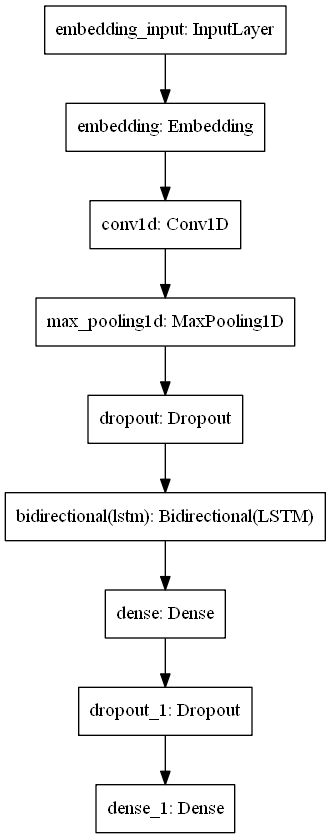

In [55]:
tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
)

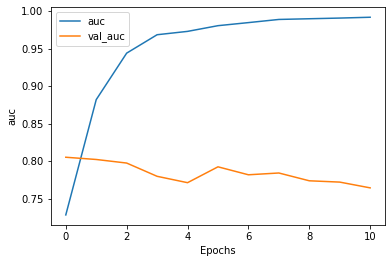

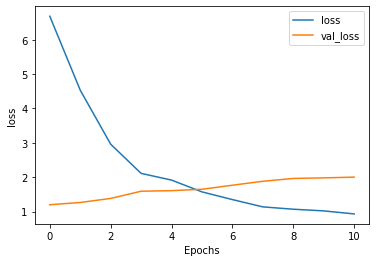

In [56]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "auc")
plot_graphs(history, "loss")

In [57]:
score = model.evaluate(valid_padded, validation_labels)
print("Loss = {}".format(score[0]))
print("Accuracy = {0:.2f}%".format(score[1]*100))
print(score)

124/124 [==============================] - 1s 7ms/step - loss: 1.2001 - accuracy: 0.8398 - precision: 0.7342 - recall: 0.3117 - auc: 0.8053
Loss = 1.2001125812530518
Accuracy = 83.98%
[1.2001125812530518, 0.8397778868675232, 0.7342449426651001, 0.31171125173568726, 0.8053451776504517]


In [58]:
y_pred = model.predict_classes(valid_padded)

accuracy = accuracy_score(valid_label, y_pred)
precision = precision_score(valid_label, y_pred, average='macro')
recall = recall_score(valid_label, y_pred, average='macro')
f1 = f1_score(valid_label, y_pred, average='macro')

print("Accuracy = {0:.2f}".format(accuracy*100))
print("Precision = {0:.4f}".format(precision))
print("Recall = {0:.4f}".format(recall))
print("F1-score = {0:.4f}".format(f1))

C:\Users\phvpa\anaconda3\envs\NLP\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Accuracy = 49.87
Precision = 0.4397
Recall = 0.5072
F1-score = 0.4384


In [59]:
confusion_matrix(valid_label,y_pred)

array([[ 209,   45,   97,   17,   70],
       [ 188,  144,   63,   14,   71],
       [ 474,  102, 1196,  146,  339],
       [   7,    5,   13,  131,   20],
       [ 155,   38,   66,   56,  296]], dtype=int64)

In [60]:
print(classification_report(valid_label,y_pred))

              precision    recall  f1-score   support

           0       0.20      0.48      0.28       438
           1       0.43      0.30      0.35       480
           2       0.83      0.53      0.65      2257
           3       0.36      0.74      0.49       176
           4       0.37      0.48      0.42       611

    accuracy                           0.50      3962
   macro avg       0.44      0.51      0.44      3962
weighted avg       0.62      0.50      0.53      3962



In [61]:
# Define a function to prepare the new reviews for use with a model
# and then use the model to predict the sentiment of the new reviews           

def predict_review(model, reviews):
  # Create the sequences
  padding_type='post'
  sample_sequences = tokenizer.texts_to_sequences(reviews)
  reviews_padded = tf.keras.preprocessing.sequence.pad_sequences(sample_sequences, padding=padding_type, 
                                 maxlen=max_length) 
  classes = model.predict_classes(reviews_padded)
  classes_prob = model.predict(reviews_padded)
  for x in range(len(reviews_padded)):
    print(reviews[x])
    print(le.inverse_transform([classes[x]]))
    print(classes_prob[x])
    print('\n')


In [62]:
sample_test = test_text[0:10]
sample_test

['வீர செங்குந்தர் சார்பாக இந்த திரைப்படம் வெற்றி பெற வாழ்த்துக்கள் இயக்குனர் மோகன்g அவர்களுக்கு எங்கள் சமுதாயத்தின் சார்பாக வாழ்த்துக்கள்',
 'teruk ah irukku  mokke movie  waste of time',
 'manitha samuthaayam amaipil irunthu intha padam vetri adaiya vaalthukal',
 'jj mam we miss u',
 'subtitle me traller dekhne wale like karo',
 'என்னடா இது சிஸ்டத்தை வச்சு செய்ஞ்சுட்டானுங்க ',
 'ஒரு ஆளு உன்ன எதிர்த்தா நீ வளர அதுவே  பல கூட்டமே உன்னை எதுத்து கதருதுனா  நீ வளந்துட்டனு அர்த்தம்   இப்படம் நாடக காதலுக்கும் உன்மை காதலை ஆனவ கொலை செய்வோர்க்கு சாட்டை அடியாக இருக்கும் என எதிர் பார்க்கப்படுகிறது வெற்றி பெற வாழ்த்துக்கள்',
 'ayutha ezhuthu 2 semmai m waiting',
 '150 to 155  vera level mass',
 '16 varushama rajini arasiyalukku varuvennu sollittu irukkaaru aaana innum varala ha ha ha']

In [63]:
predict_review(model, sample_test)

C:\Users\phvpa\anaconda3\envs\NLP\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


வீர செங்குந்தர் சார்பாக இந்த திரைப்படம் வெற்றி பெற வாழ்த்துக்கள் இயக்குனர் மோகன்g அவர்களுக்கு எங்கள் சமுதாயத்தின் சார்பாக வாழ்த்துக்கள்
['Positive']
[0.10197422 0.01942123 0.8394699  0.0109387  0.02819582]


teruk ah irukku  mokke movie  waste of time
['Mixed_feelings']
[0.3541404  0.2770863  0.15789732 0.02842883 0.18244717]


manitha samuthaayam amaipil irunthu intha padam vetri adaiya vaalthukal
['Positive']
[0.1434817  0.0322625  0.76343954 0.01768217 0.04313415]


jj mam we miss u
['unknown_state']
[0.13199277 0.08835935 0.25241014 0.19118413 0.33605355]


subtitle me traller dekhne wale like karo
['not-Tamil']
[0.0216984  0.02174582 0.02086074 0.9025296  0.03316541]


என்னடா இது சிஸ்டத்தை வச்சு செய்ஞ்சுட்டானுங்க 
['Mixed_feelings']
[0.32134455 0.25862196 0.14108345 0.04162826 0.23732191]


ஒரு ஆளு உன்ன எதிர்த்தா நீ வளர அதுவே  பல கூட்டமே உன்னை எதுத்து கதருதுனா  நீ வளந்துட்டனு அர்த்தம்   இப்படம் நாடக காதலுக்கும் உன்மை காதலை ஆனவ கொலை செய்வோர்க்கு சாட்டை அடியாக இருக்கும் என எதிர் பார

In [64]:
classes = model.predict_classes(test_padded)
pred = []

for i in range(len(classes)):
  pred.append(le.inverse_transform([classes[i]])[0])

In [65]:
#pred[:]

In [66]:
pred_df = pd.DataFrame(pred, columns=['label'])
pred_df.head()

,label
0,Positive
1,Mixed_feelings
2,Positive
3,unknown_state
4,not-Tamil


In [67]:
result = pd.concat([test_df, pred_df], axis=1)
result.head()

,id,text,label
0,Tam_1,வீர செங்குந்தர் சார்பாக இந்த திரைப்படம் வெற்றி...,Positive
1,Tam_2,teruk ah irukku mokke movie waste of time,Mixed_feelings
2,Tam_3,manitha samuthaayam amaipil irunthu intha pada...,Positive
3,Tam_4,jj mam we miss u,unknown_state
4,Tam_5,subtitle me traller dekhne wale like karo,not-Tamil


In [68]:
result.to_csv('CNN+BiLSTM_Tamil_Test_Pred_Labels_22-06-2021.csv', sep = '\t', index=False)

In [69]:
Valid_classes = model.predict_classes(valid_padded)
Valid_pred = []

for i in range(len(Valid_classes)):
    Valid_pred.append(le.inverse_transform([Valid_classes[i]])[0])

C:\Users\phvpa\anaconda3\envs\NLP\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [70]:
Valid_classes.shape

(3962,)

In [71]:
Valid_pred_df = pd.DataFrame(Valid_pred, columns=['Predicted label'])
Valid_pred_df.head()

,Predicted label
0,not-Tamil
1,Positive
2,Positive
3,Positive
4,Mixed_feelings


In [72]:
Valid_result = pd.concat([valid_df, Valid_pred_df], axis=1)
Valid_result

,text,category,Predicted label
0,40 songsuperbkamallllla im waiting for dis so...,unknown_state,not-Tamil
1,கணத்ததோர் அகமுடையார் சார்பாக படம் வெற்றி அடைய...,Positive,Positive
2,thalavia neenga veera level boss and neega tha...,Positive,Positive
3,oru padam patha fellvera level music,Positive,Positive
4,hairstyle than mattama iruku adhu mattum mathi...,unknown_state,Mixed_feelings
...,...,...,...
3957,நாடக காதல் மிகப்பெரிய தவறு இதை தான் இந்த படம் ...,Positive,Positive
3958,so long to see you suriya,not-Tamil,not-Tamil
3959,super sk ettan adipoli makkalle dec20 waiti...,Mixed_feelings,Negative
3960,minimum 50m viewa vara veppoma all thala fans,Positive,Positive


In [73]:
Valid_result.to_csv('CNN+BiLSTM_Tamil_Valid_Pred_Labels_22-06-2021.csv', sep = '\t', index=False)

In [74]:
valid_df

,text,category
0,40 songsuperbkamallllla im waiting for dis so...,unknown_state
1,கணத்ததோர் அகமுடையார் சார்பாக படம் வெற்றி அடைய...,Positive
2,thalavia neenga veera level boss and neega tha...,Positive
3,oru padam patha fellvera level music,Positive
4,hairstyle than mattama iruku adhu mattum mathi...,unknown_state
...,...,...
3957,நாடக காதல் மிகப்பெரிய தவறு இதை தான் இந்த படம் ...,Positive
3958,so long to see you suriya,not-Tamil
3959,super sk ettan adipoli makkalle dec20 waiti...,Mixed_feelings
3960,minimum 50m viewa vara veppoma all thala fans,Positive


In [75]:
d = pd.read_csv("CNN+BiLSTM_Tamil_Valid_Pred_Labels_22-06-2021.csv", sep='\t')
d

,text,category,Predicted label
0,40 songsuperbkamallllla im waiting for dis so...,unknown_state,not-Tamil
1,கணத்ததோர் அகமுடையார் சார்பாக படம் வெற்றி அடைய...,Positive,Positive
2,thalavia neenga veera level boss and neega tha...,Positive,Positive
3,oru padam patha fellvera level music,Positive,Positive
4,hairstyle than mattama iruku adhu mattum mathi...,unknown_state,Mixed_feelings
...,...,...,...
3957,நாடக காதல் மிகப்பெரிய தவறு இதை தான் இந்த படம் ...,Positive,Positive
3958,so long to see you suriya,not-Tamil,not-Tamil
3959,super sk ettan adipoli makkalle dec20 waiti...,Mixed_feelings,Negative
3960,minimum 50m viewa vara veppoma all thala fans,Positive,Positive


In [76]:
d1 = pd.read_csv("CNN+BiLSTM_Tamil_Test_Pred_Labels_22-06-2021.csv", sep='\t')
d1

,id,text,label
0,Tam_1,வீர செங்குந்தர் சார்பாக இந்த திரைப்படம் வெற்றி...,Positive
1,Tam_2,teruk ah irukku mokke movie waste of time,Mixed_feelings
2,Tam_3,manitha samuthaayam amaipil irunthu intha pada...,Positive
3,Tam_4,jj mam we miss u,unknown_state
4,Tam_5,subtitle me traller dekhne wale like karo,not-Tamil
...,...,...,...
4397,Tam_4398,ithukum dislike potta kammanattti koovaingalam...,Negative
4398,Tam_4399,suyama sinthikiravan than super hero seama dia...,Positive
4399,Tam_4400,super thalaiva nee mass dha eppavume,Positive
4400,Tam_4401,பெண்ணை அடிமையாக்க நினைக்கும் இந்த படம் தோல்வித...,Mixed_feelings
